In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report


In [2]:
data = pd.read_csv('2.Near-Earth-Objects.csv', index_col=0)
data.head(3)

,id,neo_reference_id,name,name_limited,designation,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_id,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
0,2001981,2001981,1981 Midas (1973 EA),Midas,1981,15.22,True,False,2.401900,5.370812,229,APO,0.621512,2.931360,1973-03-06,2021-10-20,Near-Earth asteroid orbits which cross the Ear...
1,2002059,2002059,2059 Baboquivari (1963 UA),Baboquivari,2059,15.97,False,False,1.700415,3.802244,268,AMO,1.238537,4.047945,1963-10-16,2021-04-15,Near-Earth asteroid orbits similar to that of ...
2,2002061,2002061,2061 Anza (1960 UA),Anza,2061,16.36,False,False,1.420872,3.177167,180,AMO,1.050403,3.478155,1960-10-22,2021-06-12,Near-Earth asteroid orbits similar to that of ...


In [3]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

In [4]:
print(data_train.shape, data_test.shape)

(19200, 17) (4800, 17)


<Axes: xlabel='is_potentially_hazardous_asteroid', ylabel='count'>

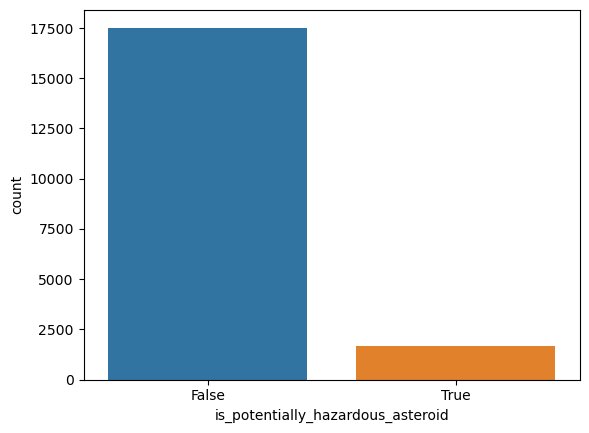

In [5]:
TARGET = 'is_potentially_hazardous_asteroid'
sns.countplot(x=data_train[TARGET])

Here we are dealing with highly imbalanced dataset.

Let's now check missing and unique values in the dataset.

In [6]:
for col in data_train.columns:
    print(col)
    print(f'Missing: {data_train[col].isna().sum()}')
    print(f'Unique: {data_train[col].nunique()}')
    print('')

id
Missing: 0
Unique: 19200

neo_reference_id
Missing: 0
Unique: 19200

name
Missing: 0
Unique: 19200

name_limited
Missing: 19084
Unique: 116

designation
Missing: 0
Unique: 19200

absolute_magnitude_h
Missing: 7
Unique: 1286

is_potentially_hazardous_asteroid
Missing: 0
Unique: 2

is_sentry_object
Missing: 0
Unique: 2

kilometers_estimated_diameter_min
Missing: 7
Unique: 1286

kilometers_estimated_diameter_max
Missing: 7
Unique: 1286

orbit_id
Missing: 0
Unique: 334

orbit_class_type
Missing: 0
Unique: 4

perihelion_distance
Missing: 0
Unique: 19200

aphelion_distance
Missing: 0
Unique: 19200

first_observation_date
Missing: 0
Unique: 5522

last_observation_date
Missing: 0
Unique: 4665

orbit_class_description
Missing: 0
Unique: 4



There's a supposition, that rows with missing `kilometers_estimated_diameter_min` are the same as rows with missing `kilometers_estimated_diameter_max`. Let's check that and also include rows, that miss the data in `absolute_magnitude_h` column

In [7]:
missing = data_train[data_train['kilometers_estimated_diameter_max'].isna() | data_train['kilometers_estimated_diameter_min'].isna() | (data_train['absolute_magnitude_h'].isna())][[TARGET, 'kilometers_estimated_diameter_min', 'kilometers_estimated_diameter_max', 'absolute_magnitude_h']]
print(missing.shape)
missing

(13, 4)


,is_potentially_hazardous_asteroid,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,absolute_magnitude_h
7092,False,0.096506,0.215794,NaN
7098,False,NaN,NaN,22.01
7292,False,0.237988,0.532157,NaN
7280,False,0.242412,0.542051,NaN
7399,False,NaN,NaN,NaN
7396,False,0.552783,1.236061,NaN
7398,True,NaN,NaN,20.70
7419,False,NaN,NaN,19.30
7299,False,NaN,NaN,27.00
7297,False,NaN,NaN,22.50


Filling the diameter data with just mean or median value seems to be a bad idea because those features could potentially have high influence on target. We'll try to figure out, if those can be derived from other features, otherwise we'll remove them

<Axes: >

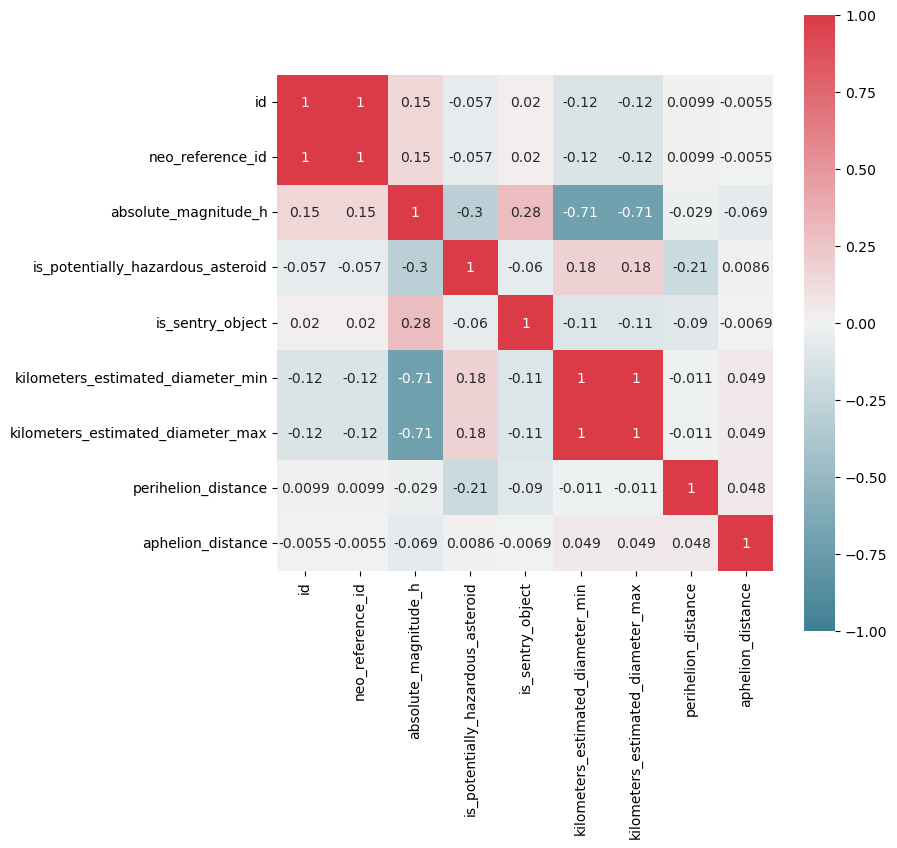

In [8]:
# build a correlation matrix to derive the dependencies of diameter features on other features

fig, axes = plt.subplots(figsize=(8, 8))
corr = data_train.corr(numeric_only=True)
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0, annot=True,
    square=True, ax=axes)

Fill missing data of diameter based on absolute_magnitude_h. First derive the equation of dependency from the LinearRegression

In [9]:
filling_na_distances = data_train[['kilometers_estimated_diameter_min', 'kilometers_estimated_diameter_max', 'absolute_magnitude_h']].dropna()
filling_na_distances.shape

(19187, 3)

In [10]:
# get linear parameters for kilometers_estimated_diameter_min

X = filling_na_distances[['absolute_magnitude_h']]
Y = filling_na_distances['kilometers_estimated_diameter_min']
model = LinearRegression()
model.fit(X,Y)
pred = model.predict(X)

# check if the prediction is adequate
err = np.mean((pred-Y)**2)
print(f'Mean squared error: {err}')

# get intercept and slope of linear regression
intercept_min_dist = model.intercept_
slope_min_dist = model.coef_[0]


Mean squared error: 0.043499993335563196


In [11]:
# get linear parameters for kilometers_estimated_diameter_max

Y = filling_na_distances['kilometers_estimated_diameter_max']
model.fit(X,Y)
pred = model.predict(X)

# check if the prediction is adequate
err = np.mean((pred-Y)**2)
print(f'Mean squared error: {err}')

# get intercept and slope of linear regression
intercept_max_dist = model.intercept_
slope_max_dist = model.coef_[0]

Mean squared error: 0.21749996668152483


In [12]:
# fill missing values of kilometers_estimated_diameter_min and kilometers_estimated_diameter_max

magnitute_col_index = data_train.columns.get_loc('absolute_magnitude_h')
km_min_col_index = data_train.columns.get_loc('kilometers_estimated_diameter_min')
km_max_col_index = data_train.columns.get_loc('kilometers_estimated_diameter_max')

for row in range(data_train.shape[0]):
    if pd.isna(data_train.iloc[row, km_min_col_index]):
        data_train.iloc[row, km_min_col_index] = intercept_min_dist + slope_min_dist * data_train.iloc[row, magnitute_col_index]
    if pd.isna(data_train.iloc[row, km_max_col_index]):
        data_train.iloc[row, km_max_col_index] = intercept_max_dist + slope_max_dist * data_train.iloc[row, magnitute_col_index]

# check if missing values are filled
print(f'Missing (min): {data_train.kilometers_estimated_diameter_min.isna().sum()}')
print(f'Missing (max): {data_train.kilometers_estimated_diameter_max.isna().sum()}')


Missing (min): 1
Missing (max): 1


That point did not have absolute_magnitude_h value as well so it stayed empty. Because it is only one value, we will remove it. 

We still have to deal with the missing data in the `absolute_magnitude_h` variable.

For this case those 8 points will be just removed. We can afford that because they belong to majority class of our target and that won't have much influence.

In [13]:
data_processed = data_train.copy()
data_processed = data_processed.drop_duplicates().dropna(subset=['absolute_magnitude_h', 'kilometers_estimated_diameter_max'], ignore_index=True)

print(data_processed.shape)
data_processed.sample(3)

(19193, 17)


,id,neo_reference_id,name,name_limited,designation,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_id,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
2787,3739620,3739620,(2016 AN66),NaN,2016 AN66,27.3,False,True,0.009216,0.020608,9,APO,0.956123,1.816631,2016-01-11,2016-01-16,Near-Earth asteroid orbits which cross the Ear...
9805,3837753,3837753,(2019 AW7),NaN,2019 AW7,22.2,False,False,0.096506,0.215794,13,APO,0.995485,3.603519,2019-01-09,2019-01-16,Near-Earth asteroid orbits which cross the Ear...
18325,3893859,3893859,(2019 WM6),NaN,2019 WM6,23.2,False,False,0.060891,0.136157,9,AMO,1.109294,2.523596,2019-11-30,2020-01-02,Near-Earth asteroid orbits similar to that of ...


### Cleaning data

Check columns one by one if they give is any information, that we can work with

**1**. `id` and `neo_reference_id` seem to be equeal, thus provide no unique information. 

In [14]:
# Check how many rows have the same ids and neo_reference_ids

data_processed[data_processed['id']==data_processed['neo_reference_id']].shape

(19193, 17)

In [15]:
# As it was thought, columns are equal.
data_processed = data_processed.drop(columns=['neo_reference_id'])

**2**. `name` has 24000 unique values, each of which consists of date of first observation + some name in numbers or letters. We have important information included in `first_observation_date`, so will get rid of `name`, `name_limited` and `designation`, because they are all just different notations of the same info.

In [16]:
data_processed = data_processed.drop(columns=['name', 'name_limited', 'designation'])

**3**. Columns `orbit_class_type` and `orbit_class_description` seem to provide the same data, i.e. types are just shortcuts for description. Let's check their destributions:

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Near-Earth asteroid orbits which cross the Earth’s orbit similar to that of 1862 Apollo'),
  Text(0, 1, 'Near-Earth asteroid orbits similar to that of 1221 Amor'),
  Text(0, 2, 'Near-Earth asteroid orbits similar to that of 2062 Aten'),
  Text(0, 3, 'An asteroid orbit contained entirely within the orbit of the Earth - Interior Earth Object')])

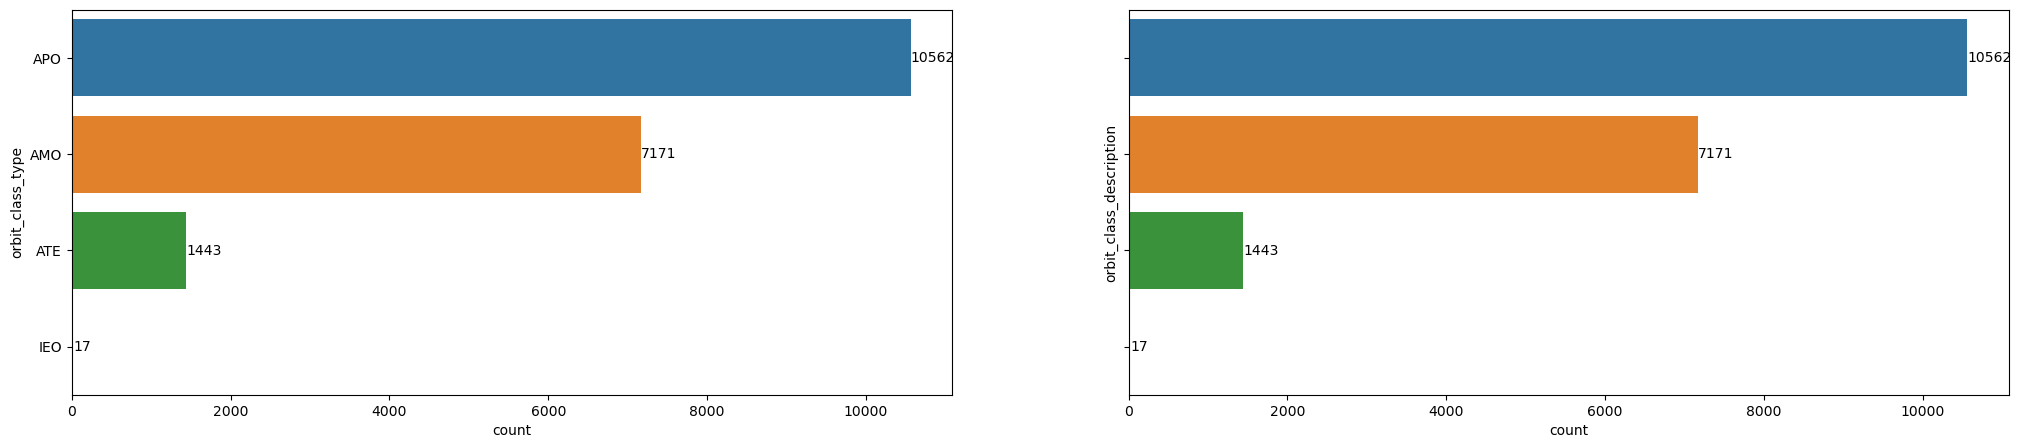

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (25,5))

# plot 1
ax = sns.countplot(y=data_processed['orbit_class_type'],
                   order=data_processed['orbit_class_type'].value_counts(ascending=False).index, ax=axes[0])
abs_values = data_processed['orbit_class_type'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

# plot 2
ax = sns.countplot(y=data_processed['orbit_class_description'],
                   order=data_processed['orbit_class_description'].value_counts(ascending=False).index, ax=axes[1]);
abs_values = data_processed['orbit_class_description'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
plt.yticks(visible=False)

Columns `orbit_class_description` and `orbit_class_type` have the same info, we'll skip the first one

In [18]:
data_processed = data_processed.drop(columns=['orbit_class_description'])

**4**. `is_potentially_hazardous_asteroid`, `is_sentry_object` are of boolean type and models can't work with that. Thus we substitute the values to [0,1]. `orbit_class_type` has strings as inputs, but only of 4 classes, which we can easily substitute with [0,1,2,3]

In [19]:
# Substitute booleans and categiries with numbers
boolean_mapping = {True: 1, False: 0}
orbit_class_type_mapping = {'APO': 0, 'AMO': 1, 'ATE': 2, 'IEO':3}

data_processed['is_sentry_object'].replace(boolean_mapping.keys(), boolean_mapping.values(), inplace=True)
data_processed['orbit_class_type'].replace(orbit_class_type_mapping.keys(), orbit_class_type_mapping.values(), inplace=True)
data_processed['is_potentially_hazardous_asteroid'].replace(boolean_mapping.keys(), boolean_mapping.values(), inplace=True)

data_processed.sample(3)

,id,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_id,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date
7283,54054409,23.2,0,0,0.060891,0.136157,6,1,1.162649,3.508391,2020-09-14,2020-10-13
16177,3753857,24.7,0,0,0.030518,0.068240,9,0,0.888958,1.322173,2016-06-02,2016-07-06
576,2511008,18.5,1,0,0.530341,1.185878,63,0,0.905596,4.287630,2010-01-12,2018-03-29


**5**. Last 2 columns to deal with are `date` columns. We can derive new features of those, because the date itself can not be processed. 

When trying to calculate differences between dates, the error ocured, saying that some values in date columns contain `?` char and thus cant be processed

In [20]:
# find all row indeces, where ? occurs

for row in range(data_processed.shape[0]):
    if ('?' in data_processed.iloc[row, -2]) | ('?' in data_processed.iloc[row, -1]):
        print(row)

15993


In [21]:
missing_row = 15993
data_processed.iloc[missing_row, :]

id                                      3843794
absolute_magnitude_h                       20.6
is_potentially_hazardous_asteroid             0
is_sentry_object                              0
kilometers_estimated_diameter_min       0.20163
kilometers_estimated_diameter_max      0.450858
orbit_id                              MPO508629
orbit_class_type                              1
perihelion_distance                    1.077174
aphelion_distance                      1.865083
first_observation_date               2008-??-??
last_observation_date                2019-09-06
Name: 15993, dtype: object

There's only one missing date in `first_observation_date` column. We'll try to google it, if there's no information, we'll remove it or substitute with 2008-01-01 

Let's find the name of an asteroid from original dataset by id

In [22]:
data_train[data_train['id']== 3843794][['id', 'name', 'first_observation_date']]

,id,name,first_observation_date
20702,3843794,(2019 RN1),2008-??-??


After a quick search there seem to be no information about `first_observation_date` of 2019 RN1 asteroid. It belogs to the majority class of target, so we will just substitute the date with 2008-01-01 

In [23]:
data_processed.iloc[missing_row, -2] = '2008-01-01'

In [24]:
# Add columns 'days_from_las_obs' and 'days_btwn_1_last_obs' and set date of data collection (from kaggle)
date_of_data_collection = pd.to_datetime('2022-08-07', format='%Y-%m-%d')
data_processed['days_from_last_obs'] = 0
data_processed['days_btwn_1_last_obs'] = 0

for row in range(data_processed.shape[0]):
    
    # data_processed.iloc[row, -4] = pd.to_datetime(data_processed.iloc[row, -4], format='%Y-%m-%d')
    # data_processed.iloc[row, -3] = pd.to_datetime(data_processed.iloc[row, -3], format='%Y-%m-%d')

    # we use this hard-to-read notation instead of above one (commented) 
    # because it reduces computation time almost twice. and we won't need date columns in the end of the day
    data_processed.iloc[row, -1] = (pd.to_datetime(data_processed.iloc[row, -3], format='%Y-%m-%d') - pd.to_datetime(data_processed.iloc[row, -4], format='%Y-%m-%d')).days
    data_processed.iloc[row, -2] = (date_of_data_collection - pd.to_datetime(data_processed.iloc[row, -3], format='%Y-%m-%d')).days

data_processed.sample(3)

,id,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_id,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,days_from_last_obs,days_btwn_1_last_obs
16677,3712425,24.9,0,0,0.027833,0.062236,8,1,1.124345,2.876329,2015-02-17,2015-03-18,2699,29
17593,3794969,30.0,0,1,0.002658,0.005943,3,0,0.969309,1.183667,2017-12-20,2017-12-30,1681,10
9218,3837918,24.1,0,0,0.040230,0.089958,13,2,0.805051,1.150038,2019-01-05,2020-01-29,921,389


Now we remove date columns

In [25]:
data_processed = data_processed.drop(columns=['first_observation_date', 'last_observation_date'])
data_processed.sample(3)

,id,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_id,orbit_class_type,perihelion_distance,aphelion_distance,days_from_last_obs,days_btwn_1_last_obs
13642,3638336,25.500,0,0,0.021113,0.047211,6,1,1.100066,3.030091,3376,2
16339,3477698,20.500,0,0,0.211132,0.472106,15,1,1.170955,4.254392,1365,3280
16240,3441851,26.102,0,0,0.016001,0.035780,11,1,1.039936,3.495381,4976,0


### Feature engineering - &#x2705; done.

Next we have to scale data and create a model to train it.

### Data Preparation

`orbit_id` is of a non-numeric data type and has lots of classes, so we'll use oneHotEncoding technique to make it binary.

In [26]:
orbit_id_dummies = pd.get_dummies(data_processed.orbit_id, dtype=int, prefix='orbit_id', drop_first=True)
data_processed = pd.concat([data_processed.drop(columns = 'orbit_id'), orbit_id_dummies], axis=1)
data_processed.sample(3)

,id,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_class_type,perihelion_distance,aphelion_distance,days_from_last_obs,...,orbit_id_93,orbit_id_94,orbit_id_95,orbit_id_96,orbit_id_97,orbit_id_98,orbit_id_99,orbit_id_E2021-CI3,orbit_id_MPO392510,orbit_id_MPO508629
12471,3454731,17.8,1,0,0.732074,1.636967,0,0.913111,3.846842,578,...,0,0,0,0,0,0,0,0,0,0
11637,54016966,25.9,0,0,0.017561,0.039268,0,0.936829,2.586147,823,...,0,0,0,0,0,0,0,0,0,0
14359,54016818,21.4,0,0,0.139494,0.311918,1,1.094175,1.996465,637,...,0,0,0,0,0,0,0,0,0,0


The rest of data we'll scale to range [-1,1]

In [27]:
cols_to_normalize = ['absolute_magnitude_h', 'kilometers_estimated_diameter_min', 'kilometers_estimated_diameter_max',
                      'orbit_class_type', 'perihelion_distance', 'aphelion_distance', 'days_from_last_obs', 'days_btwn_1_last_obs']
scaler = StandardScaler()

data_processed[cols_to_normalize] = scaler.fit_transform(data_processed[cols_to_normalize])
data_processed.sample(3)

,id,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_class_type,perihelion_distance,aphelion_distance,days_from_last_obs,...,orbit_id_93,orbit_id_94,orbit_id_95,orbit_id_96,orbit_id_97,orbit_id_98,orbit_id_99,orbit_id_E2021-CI3,orbit_id_MPO392510,orbit_id_MPO508629
3643,3838865,0.29192,0,0,-0.412171,-0.412171,-0.827580,-0.119422,-0.250573,-0.648989,...,0,0,0,0,0,0,0,0,0,0
291,3472700,1.00299,0,0,-0.508501,-0.508501,2.315227,-0.715981,-0.315553,1.424494,...,0,0,0,0,0,0,0,0,0,0
9849,3745104,0.32578,0,0,-0.419166,-0.419166,-0.827580,-0.305380,0.010307,0.108684,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Divide data to dependent and independent variables
X = data_processed.drop(columns=[TARGET, 'id'])
Y = data_processed[TARGET]

# Divide data to train and test sets to check the performance of the model later
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [29]:
# initialize a Logistic Regression model, train and test on train data

model = LogisticRegression(max_iter = 10000)
model.fit(x_train, y_train)
y_pred = model.predict(x_train)

scores = cross_val_score(model, x_train, y_train, cv=5, scoring='f1')
f1_mean_score = round(np.mean(scores),2)
f1_std = round(np.std(scores),2)

report = classification_report(y_train, y_pred)

print(f'F1 score on train data:\nmean = {f1_mean_score} | std = {f1_std}')
print(report)


F1 score on train data:
mean = 0.2 | std = 0.03
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     14014
           1       0.47      0.17      0.25      1340

    accuracy                           0.91     15354
   macro avg       0.70      0.58      0.60     15354
weighted avg       0.89      0.91      0.89     15354



To fix this huge difference in metrics for minority and majority class, we first try the easiest, yet not the best, method to balance data - we undersample the majority class.

In [30]:
VALUES = [1, 0]

# set the random seed for reproducibility
random.seed(97)

# figure out the minimum number of the values
value_counts = []
for value in VALUES:
    value_counts.append(data_processed[data_processed[TARGET] == value].shape[0])
min_num_rows = min(value_counts)
for index, value in enumerate(VALUES):
    print(f"There were {value_counts[index]} {value}s in the dataset - the kept amount is {min_num_rows}.")

# randomly select the minumum number of rows each of the values
chosen_ids = []
for label in VALUES:
    ids = data_processed[data_processed[TARGET] == label].index
    chosen_ids.extend(random.sample(list(ids), min_num_rows))

# remove the non-chosen ids from the dataset
dataset_balanced = data_processed.drop(data_processed.index[list(set(range(data_processed.shape[0])) - set(chosen_ids))])
print(dataset_balanced.shape)
dataset_balanced.sample(10)

There were 1677 1s in the dataset - the kept amount is 1677.
There were 17516 0s in the dataset - the kept amount is 1677.
(3354, 344)


,id,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_class_type,perihelion_distance,aphelion_distance,days_from_last_obs,...,orbit_id_93,orbit_id_94,orbit_id_95,orbit_id_96,orbit_id_97,orbit_id_98,orbit_id_99,orbit_id_E2021-CI3,orbit_id_MPO392510,orbit_id_MPO508629
1277,3653190,-0.551206,1,0,-0.078370,-0.078370,-0.827580,0.274668,-0.249497,-1.124459,...,0,0,0,0,0,0,0,0,0,0
14338,3448785,1.307734,0,0,-0.528550,-0.528550,-0.827580,-0.176670,-0.176149,1.570442,...,0,0,0,0,0,0,0,0,0,0
13729,3753092,-0.913513,1,0,0.233174,0.233174,-0.827580,-2.579402,-0.072347,-0.991624,...,0,0,0,0,0,0,0,0,0,0
6737,3514546,-0.791616,0,0,0.110839,0.110839,0.743823,1.149476,0.099492,1.297930,...,0,0,0,0,0,0,0,0,0,0
7927,3651206,-0.385290,0,0,-0.177195,-0.177195,0.743823,1.257697,0.129879,0.561350,...,0,0,0,0,0,0,0,0,0,0
9173,2538212,-1.208100,1,0,0.627785,0.627785,-0.827580,-2.032068,0.192712,-1.136431,...,0,0,0,0,0,0,0,0,0,0
18842,3565474,-1.164081,1,0,0.558322,0.558322,-0.827580,-2.411400,-0.084836,-0.750468,...,0,0,0,0,0,0,0,0,0,0
9119,3720439,-0.825476,0,0,0.142812,0.142812,-0.827580,-2.062682,-0.069944,0.250071,...,0,0,0,0,0,0,0,0,0,0
1020,2496869,-1.638128,0,0,1.577790,1.577790,-0.827580,-0.472535,0.221175,-0.306354,...,0,0,0,0,0,0,0,0,0,0
7765,54013543,0.258059,0,0,-0.404846,-0.404846,-0.827580,-0.183350,-0.270751,-0.738496,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Repeat the training procedure again:

# Divide data to dependent and independent variables
X = dataset_balanced.drop(columns=[TARGET, 'id'])
Y = dataset_balanced[TARGET]

# Divide data to train and test sets to check the performance of the model later
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter = 10000)
model.fit(x_train, y_train)
y_pred = model.predict(x_train)

scores = cross_val_score(model, x_train, y_train, cv=5, scoring='f1')
f1_mean_score = round(np.mean(scores),2)
f1_std = round(np.std(scores),2)

report = classification_report(y_train, y_pred)

print(f'F1 score on train data:\nmean = {f1_mean_score} | std = {f1_std}')
print(report)

F1 score on train data:
mean = 0.85 | std = 0.01
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1340
           1       0.84      0.90      0.87      1343

    accuracy                           0.86      2683
   macro avg       0.87      0.86      0.86      2683
weighted avg       0.87      0.86      0.86      2683



In [32]:
# Test the model on the data, that it has never seen, but which however gave an impact on scaling and feature engineering:

y_pred = model.predict(x_test)

scores = cross_val_score(model, x_test, y_test, cv=5, scoring='f1')
f1_mean_score = round(np.mean(scores),2)
f1_std = round(np.std(scores),2)

report = classification_report(y_test, y_pred)

print(f'F1 score on validation data:\nmean = {f1_mean_score} | std = {f1_std}')
print(report)

F1 score on validation data:
mean = 0.84 | std = 0.05
              precision    recall  f1-score   support

           0       0.88      0.80      0.83       337
           1       0.81      0.89      0.85       334

    accuracy                           0.84       671
   macro avg       0.84      0.84      0.84       671
weighted avg       0.84      0.84      0.84       671



# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
